In [226]:
#|hide
## Standard libraries
import os
import math
import numpy as np
import time
from fastcore.all import *
from nbdev.showdoc import *

# Configure environment
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false' # Tells Jax not to hog all of the memory to this process.

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm, trange

## project specifics
import diffusion_curvature
import pygsp
import jax
import jax.numpy as jnp
jax.devices()

from diffusion_curvature.graphs import *
from diffusion_curvature.datasets import *
from diffusion_curvature.core import *
from diffusion_curvature.utils import *
from diffusion_curvature.comparison_space import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [227]:
X, ks = ellipsoid(2000, seed=19323)
X

array([[ 2.00397824, -0.41691384,  0.71437483],
       [ 1.27475224, -0.11175413,  0.90350592],
       [-1.91620722,  0.99866728,  0.58539095],
       ...,
       [-2.97769204, -0.03548212,  0.12042399],
       [ 2.35053893, -0.31803095,  0.60068419],
       [-0.5358212 , -1.86937732, -0.30733797]])

# 2a2 Comparing Curvatures on Toy Manifolds
> Which will emerge victorious?

The comparison consists of two parts:
1. A figure showing the visual differences, both in 3d scatter plots, and correlation plots.
2. Tables computing the resilience to noise across methods.

# Machinery

Load up the results:

In [245]:
curvatures = {
    'Ground Truth Curvature' : np.load("../../results/toy_datasets_ground_truth_curvatures_1000.npz"),
    # 'AdaL-PCA' : np.load("../../results/toy_dataset_toy_datasets_principal_curvature_heuristic.npz"),
    'AdaL-PCA' : np.load("../../results/toy_dataset_toy_datasets_principal_curvature_heuristic_filtered.npz"), # outlier points filtered out
    # 'AdaL-PCA' : np.load("../../results/toy_dataset_toy_datasets_principal_curvature_no_heuristic_08_15.npz"),
    'Unsigned Diffusion Curvature' : np.load("../../results/toy_dataset_neurips_laziness_no_comparison.npz"),
    # 'Diffusion Curvature' : np.load("../../results/toy_dataset_wasserstein_fixed_ollivier.npz"),
    'Hickok & Blumberg' : np.load("../../results/toy_dataset_toy_datasets_hickock_curvature_r3.14.npz"),
}
scaled_curvatures = dict(curvatures)

And the data

In [246]:
Xs = np.load("../../results/toy_data_saved_1000.npz")
Ks = np.load("../../results/toy_datasets_ground_truth_curvatures_1000.npz")

In [247]:
Xs['Ellipsoid'].shape

(1000, 3)

In [248]:
# # Establish Datasets
# n_points = 2000
# Xs = {}
# Ks = {}
# Xs['Torus'], Ks['Torus'] = torus(n_points, use_guide_points=False, seed=19323)
# Xs['Saddle'], Ks['Saddle'] = paraboloid(n_points, use_guide_points=False, seed=19323)
# Xs['sphere'], Ks['sphere'] = sphere(n_points,)
# Xs['Ellipsoid'], Ks['Ellipsoid'] = ellipsoid(n_points, seed=19323)
# Xs['hyperboloid'], Ks['hyperboloid'] = hyperboloid(n_points, seed=19323)
# # Noised Versions
# for noise_scale in [0.1, 0.2, 0.3, 0.4, 0.5]:
#     Xs[f'Torus noise = {noise_scale}'], Ks[f'Torus noise = {noise_scale}'] = torus(n_points, use_guide_points=False, seed=19323, noise = noise_scale)
#     # Xs['plane noise = {noise_scale}'] = np.hstack([plane(n_points, dim=2),np.zeros((n_points,1))])
#     # Ks['plane noise = {noise_scale}'] = np.zeros(len(Xs['plane']))
#     Xs[f'Saddle noise = {noise_scale}'], Ks[f'Saddle noise = {noise_scale}'] = paraboloid(n_points, use_guide_points=False, seed=19323, noise = noise_scale)
#     # Xs['sphere = {noise_scale}'], Ks['sphere = {noise_scale}'] = sphere(n_points,)
#     Xs[f'Ellipsoid noise = {noise_scale}'], Ks[f'Ellipsoid noise = {noise_scale}'] = ellipsoid(n_points, seed=19323, noise = noise_scale)
#     Xs[f'hyperboloid noise = {noise_scale}'], Ks[f'hyperboloid noise = {noise_scale}'] = hyperboloid(n_points, seed=19323, noise = noise_scale)

In [249]:
curvatures['Hickok & Blumberg']['Torus'].shape

(1000,)

# Results

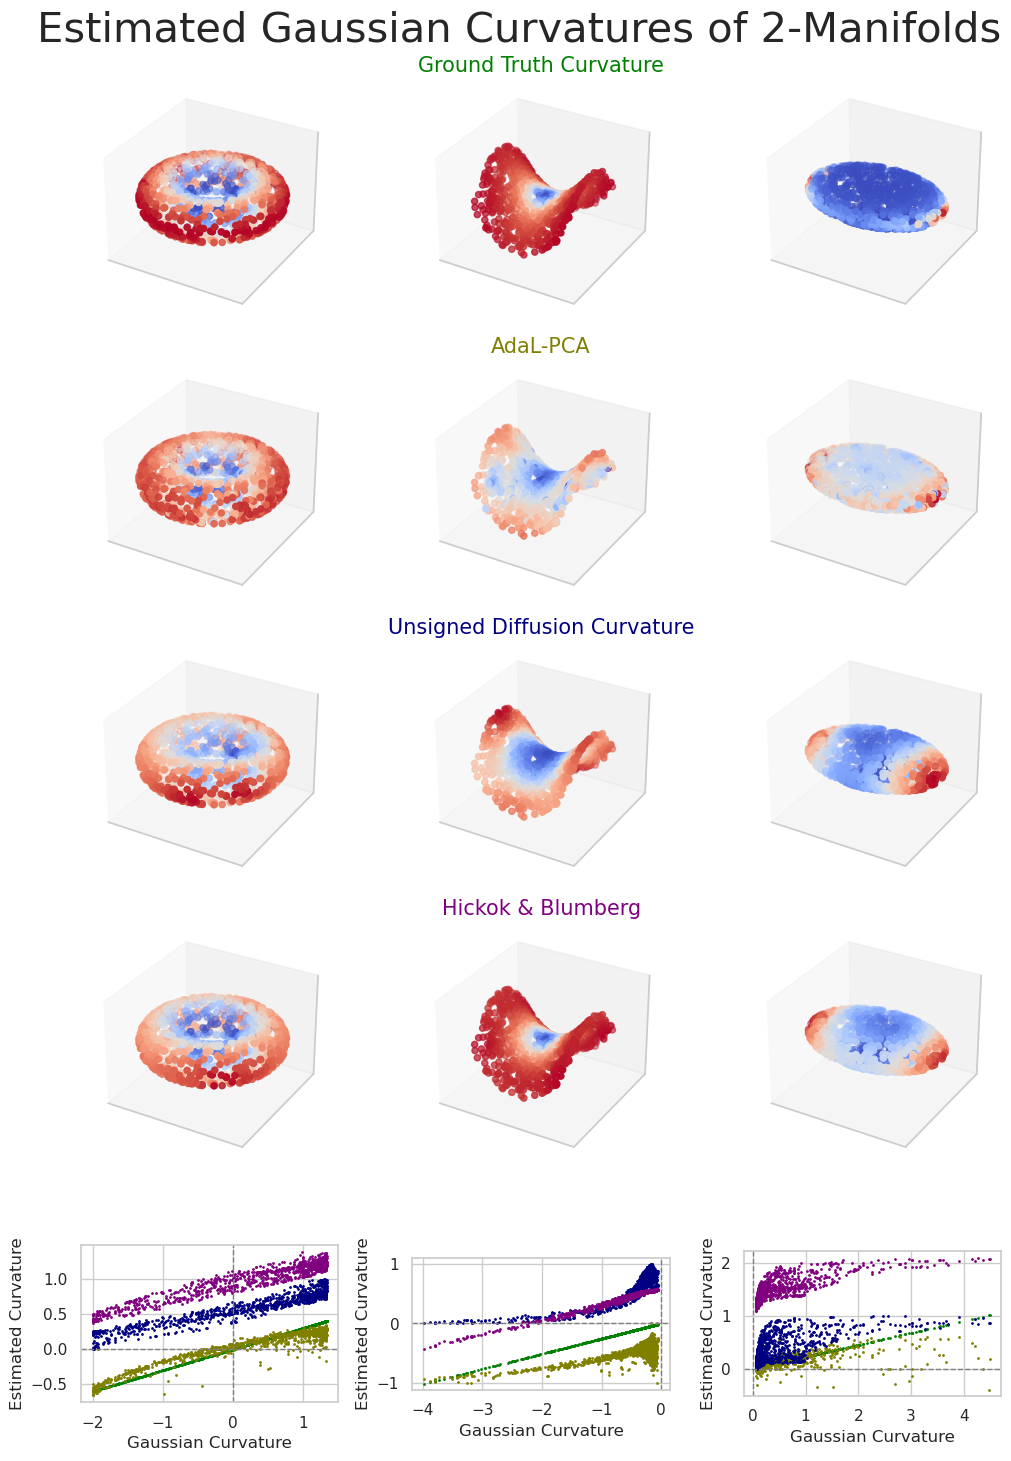

In [250]:
#| label: fig-2-manifolds-visual-comparison
#| fig-cap: Diffusion Curvature vs Gaussian Curvature on 2-Manifolds.
#| fig-alt: The Torus, Saddle, Ellipsoid are shown in the first row, colored by the diffusion curvature. The second row shows the scatter plot of the Gaussian curvature vs the diffusion curvature, colored by the diffusion curvature. The origin lines are highlighted in the scatter plots.

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from matplotlib import colors
import numpy as np

# Assuming Xs, labels, ground_truth_labels, and key_names are defined
# For example:
key_names = ['Torus', 'Saddle', 'Ellipsoid']
labels = curvatures
ground_truth_labels = Ks

# Set the style of seaborn
sns.set(style="whitegrid")

fig_shape = (len(curvatures.keys()) + 1, len(key_names))
method_colors = ['green', 'olive', 'navy', 'purple']
assert len(method_colors) == len(curvatures.keys())

ordered_keys = curvatures.keys() #['Gaussian', 'Adal-PCA', 'Unsigned Diffusion Curvature', 'Hickok & Blumberg']
assert set(ordered_keys) == set(curvatures.keys())

# Create a figure and axes with 2 rows and 3 columns
fig, axs = plt.subplots(fig_shape[0], fig_shape[1], figsize=(fig_shape[0]*2, fig_shape[1]*5), subplot_kw={'projection': '3d'} if plt.matplotlib.__version__ < '3.4.0' else None)

for i, key in enumerate(key_names):
    # 3D scatter plot for the first row
    lim = np.max(np.linalg.norm(Xs[key], axis=1))
    # if plt.matplotlib.__version__ >= '3.4.0':

    # plot the curvature for each method
    for j, method_name in enumerate(ordered_keys):
        axs[j, i].remove()
        axs[j, i] = fig.add_subplot(fig_shape[0], fig_shape[1], i + j*fig_shape[1] + 1, projection='3d')
        axs[j, i].axes.set_xlim3d(left=-lim, right=lim)
        axs[j, i].axes.set_ylim3d(bottom=-lim, top=lim)
        axs[j, i].axes.set_zlim3d(bottom=-lim, top=lim)
        axs[j, i].set_xticks([])
        axs[j, i].set_yticks([])
        axs[j, i].set_zticks([])

        scaled_labels = labels[method_name][key]
        scaled_labels = scaled_labels / (max(scaled_labels) - min(scaled_labels))
        scatter3d = axs[j, i].scatter(Xs[key][:, 0], Xs[key][:, 1], Xs[key][:, 2], c=scaled_labels, cmap = 'coolwarm')
        if i == 1:
            axs[j, i].set_title(f'{method_name}',fontsize=15, c = method_colors[j])

    # Scatter plot for the second row, colored by labels
    # axs[j+1, i].remove()
    # axs[j+1, i] = fig.add_subplot(fig_shape[0], fig_shape[1], i+4)
    for k, method_name in enumerate(ordered_keys):
        # min max scaling
        scaled_labels = labels[method_name][key]
        scaled_labels = scaled_labels / (max(scaled_labels) - min(scaled_labels))
        scatter2d = axs[j+1, i].scatter(ground_truth_labels[key], scaled_labels, c = method_colors[k], s = 1)
        axs[j+1,i].set_aspect('equal')
    # axs[1, i].set_title(f'')
    axs[j+1, i].set_xlabel('Gaussian Curvature')
    axs[j+1, i].set_ylabel('Estimated Curvature')
    
    
    # Highlight the origin lines in 2D scatter plots
    axs[j+1, i].axhline(0, color='gray', linewidth=1, linestyle='--')
    axs[j+1, i].axvline(0, color='gray', linewidth=1, linestyle='--')

    # # Add colorbar for each subplot
    # fig.colorbar(scatter3d, ax=axs[0, i], fraction=0.046, pad=0.04)
    # fig.colorbar(scatter2d, ax=axs[1, i], fraction=0.046, pad=0.04)
plt.suptitle("Estimated Gaussian Curvatures of 2-Manifolds", fontsize=30)
plt.tight_layout()
plt.show()


In [251]:
Xs['Ellipsoid']

array([[ 0.63842898, -0.41691384, -0.95459822],
       [-1.08160955,  0.99866728,  0.78783205],
       [-2.40019712, -0.81698673, -0.43934956],
       ...,
       [ 0.35009997,  1.90351948,  0.28378602],
       [-1.95352695,  0.5126914 , -0.71432287],
       [-1.21028093, -1.18071427,  0.69908878]])

# Table

In [252]:
import pandas as pd

In [253]:
from sklearn.metrics import mean_squared_error
def root_mse_between(labels, method, dataset):
    truth = labels['Ground Truth Curvature'][dataset]
    computed = labels[method][dataset]
    return np.sqrt(mean_squared_error(truth, computed))

In [254]:
from scipy.stats import energy_distance
def energy_between(labels, method, dataset):
    truth = labels['Ground Truth Curvature'][dataset]
    computed = labels[method][dataset]
    return energy_distance(truth, computed)

In [255]:
from scipy.stats import pearsonr
def pearson_correlation_between(labels, method, dataset):
    truth = labels['Ground Truth Curvature'][dataset]
    computed = labels[method][dataset]
    rho, confidence = pearsonr(truth, computed)
    return rho

In [256]:
noise_scales = [0.05, 0.1, 0.15, 0.2, 0.25]
dataset_names = ['Torus'] + [f'Torus noise = {x}' for x in noise_scales] + ['Saddle'] + [f'Saddle noise = {x}' for x in noise_scales] + ['Ellipsoid'] + [f'Ellipsoid noise = {x}' for x in noise_scales]

metrics_collected = {
        'RMSE':{}, 'ED':{}, 'PCC':{}
    }

for method in labels.keys():
    if method == 'Ground Truth Curvature': 
        pass
    else:
        print(method)
        metrics_collected['RMSE'][method] = {}
        metrics_collected['ED'][method] = {}
        metrics_collected['PCC'][method] = {}
        
        for dname in dataset_names:
            try:
                metrics_collected['RMSE'][method][dname] = root_mse_between(curvatures, method, dname)
                metrics_collected['ED'][method][dname] = energy_between(curvatures, method, dname)
                metrics_collected['PCC'][method][dname] = pearson_correlation_between(curvatures, method, dname)
            except KeyError:
                pass

AdaL-PCA
Unsigned Diffusion Curvature
Hickok & Blumberg


In [257]:
root_mse_between(curvatures, 'Hickok & Blumberg', 'Torus')

1.3590765614253006

In [258]:
metrics_collected['RMSE']

{'AdaL-PCA': {'Torus': 0.7905700978435937,
  'Torus noise = 0.05': 0.9806275181718459,
  'Torus noise = 0.1': 1.7017837942363958,
  'Torus noise = 0.15': 2.040606444287437,
  'Torus noise = 0.2': 2.6755425767388537,
  'Torus noise = 0.25': 2.651646020467047,
  'Saddle': 0.5966535233839613,
  'Saddle noise = 0.05': 157.15145179493663,
  'Saddle noise = 0.1': 83.54357625625143,
  'Saddle noise = 0.15': 48.49916250297099,
  'Saddle noise = 0.2': 29.631065973827525,
  'Saddle noise = 0.25': 21.95077399772847,
  'Ellipsoid': 0.6808457693342963,
  'Ellipsoid noise = 0.05': 3.7070996549869464,
  'Ellipsoid noise = 0.1': 6.693845783847647,
  'Ellipsoid noise = 0.15': 7.432934238107848,
  'Ellipsoid noise = 0.2': 6.795221348214839,
  'Ellipsoid noise = 0.25': 6.4018964322345635},
 'Unsigned Diffusion Curvature': {'Torus': 0.8943585466700803,
  'Torus noise = 0.05': 0.8919689391909543,
  'Torus noise = 0.1': 0.8995194295549708,
  'Torus noise = 0.15': 0.9025236984417024,
  'Torus noise = 0.2': 0

In [259]:
metrics_collected['ED']

{'AdaL-PCA': {'Torus': 0.6710713777673143,
  'Torus noise = 0.05': 0.6948987249417321,
  'Torus noise = 0.1': 0.8624184148230342,
  'Torus noise = 0.15': 1.0529529413054564,
  'Torus noise = 0.2': 1.2578238928580172,
  'Torus noise = 0.25': 1.345687817665302,
  'Saddle': 0.5464391871664627,
  'Saddle noise = 0.05': 5.179152950400703,
  'Saddle noise = 0.1': 6.9032245031031145,
  'Saddle noise = 0.15': 5.926859098494771,
  'Saddle noise = 0.2': 5.0193352027395495,
  'Saddle noise = 0.25': 4.513325007778283,
  'Ellipsoid': 0.2974682823164955,
  'Ellipsoid noise = 0.05': 0.5956940129754204,
  'Ellipsoid noise = 0.1': 1.0359106491365015,
  'Ellipsoid noise = 0.15': 1.6101083650276766,
  'Ellipsoid noise = 0.2': 1.9440118452763868,
  'Ellipsoid noise = 0.25': 2.0869429912647175},
 'Unsigned Diffusion Curvature': {'Torus': 0.5734058099110984,
  'Torus noise = 0.05': 0.5719564768144003,
  'Torus noise = 0.1': 0.56898172318435,
  'Torus noise = 0.15': 0.5671103821203981,
  'Torus noise = 0.2':

In [260]:
metrics_collected['PCC']

{'AdaL-PCA': {'Torus': 0.9418342861237213,
  'Torus noise = 0.05': 0.5618844421066612,
  'Torus noise = 0.1': 0.1532873682233706,
  'Torus noise = 0.15': 0.06864650155981816,
  'Torus noise = 0.2': 0.07819808196427949,
  'Torus noise = 0.25': 0.03279248667206587,
  'Saddle': 0.7396965706504889,
  'Saddle noise = 0.05': 0.03543620261425413,
  'Saddle noise = 0.1': 0.007493953387057498,
  'Saddle noise = 0.15': 0.04688203414316737,
  'Saddle noise = 0.2': 0.09609898713425272,
  'Saddle noise = 0.25': 0.17907628146479518,
  'Ellipsoid': 0.5611947908350309,
  'Ellipsoid noise = 0.05': -0.10238187360458216,
  'Ellipsoid noise = 0.1': -0.02826522666772372,
  'Ellipsoid noise = 0.15': 0.03975643506529558,
  'Ellipsoid noise = 0.2': 0.08525847089230666,
  'Ellipsoid noise = 0.25': 0.09147684842840456},
 'Unsigned Diffusion Curvature': {'Torus': 0.9481193182381812,
  'Torus noise = 0.05': 0.9418341797945845,
  'Torus noise = 0.1': 0.9312416021266787,
  'Torus noise = 0.15': 0.9085075006279271,


In [261]:


# Define the LaTeX table structure
def create_latex_table(metrics):
    header = r"""\begin{tabular}{lc|cccccc|cccccc|cccccc}
\toprule
\multirow{2}{*}{\textbf{Model}} & \multirow{2}{*}{\textbf{Metric}} & \multicolumn{6}{c|}{\textbf{Torus}} & \multicolumn{6}{c|}{\textbf{Ellipsoid}} & \multicolumn{6}{c}{\textbf{Saddle}} \\
& & 0.0 & 0.05 & 0.10 & 0.15 & 0.20 & \multicolumn{1}{c|}{0.25} & 0.0 & 0.05 & 0.10 & 0.15 & 0.20 & \multicolumn{1}{c|}{0.25} & 0.0 & 0.05 & 0.10 & 0.15 & 0.20 & 0.25 \\
\midrule
"""
    footer = r"\bottomrule\n\end{tabular}"

    # Start building the table content
    table_content = header

    # Function to find the best values for bolding
    def find_best_values(data, surfaces, noises, metric):
        best_values = {}
        for surface in surfaces:
            for noise in noises:
                key = f"{surface} noise = {noise}" if noise > 0 else surface
                values = [model_data.get(key, float('-inf') if metric == 'PCC' else float('inf')) for model_data in data.values()]
                best_value = max(values) if metric == 'PCC' else min(values)
                best_values[(surface, noise)] = best_value
        return best_values

    # Iterate over each metric
    for metric, models in metrics.items():
        best_values = find_best_values(models, ["Torus", "Ellipsoid", "Saddle"], [0, 0.05, 0.1, 0.15, 0.2, 0.25], metric)
        # Iterate over each model
        for model, data in models.items():
            model_escaped = model.replace('&', r'\&')  # Escape '&' in model names
            table_content += f"{model_escaped} & {metric} "
            for surface in ["Torus", "Ellipsoid", "Saddle"]:
                for noise in [0, 0.05, 0.1, 0.15, 0.2, 0.25]:
                    key = f"{surface} noise = {noise}" if noise > 0 else surface
                    value = data.get(key, "")
                    if value:
                        # Check if the value is the best and should be bolded
                        if value == best_values[(surface, noise)]:
                            table_content += f"& \\textbf{{{value:.3f}}} "
                        else:
                            table_content += f"& {value:.3f} "
                    else:
                        table_content += "& - "
            table_content += r"\\"
            table_content += "\n"
        table_content += r"\midrule" + "\n"

    table_content += footer
    return table_content

# Generate the LaTeX table
latex_table = create_latex_table(metrics_collected)

# Print the LaTeX table
print(latex_table)


\begin{tabular}{lc|cccccc|cccccc|cccccc}
\toprule
\multirow{2}{*}{\textbf{Model}} & \multirow{2}{*}{\textbf{Metric}} & \multicolumn{6}{c|}{\textbf{Torus}} & \multicolumn{6}{c|}{\textbf{Ellipsoid}} & \multicolumn{6}{c}{\textbf{Saddle}} \\
& & 0.0 & 0.05 & 0.10 & 0.15 & 0.20 & \multicolumn{1}{c|}{0.25} & 0.0 & 0.05 & 0.10 & 0.15 & 0.20 & \multicolumn{1}{c|}{0.25} & 0.0 & 0.05 & 0.10 & 0.15 & 0.20 & 0.25 \\
\midrule
AdaL-PCA & RMSE & \textbf{0.791} & 0.981 & 1.702 & 2.041 & 2.676 & 2.652 & 0.681 & 3.707 & 6.694 & 7.433 & 6.795 & 6.402 & \textbf{0.597} & 157.151 & 83.544 & 48.499 & 29.631 & 21.951 \\
Unsigned Diffusion Curvature & RMSE & 0.894 & \textbf{0.892} & \textbf{0.900} & 0.903 & 0.904 & 0.907 & \textbf{0.598} & \textbf{0.605} & 0.616 & \textbf{0.618} & \textbf{0.617} & \textbf{0.624} & 1.295 & \textbf{1.295} & \textbf{1.309} & \textbf{1.323} & \textbf{1.332} & \textbf{1.323} \\
Hickok \& Blumberg & RMSE & 1.359 & 1.256 & 0.928 & \textbf{0.670} & \textbf{0.601} & \textbf{0.676} & 0.

In [ ]:
# Display one part of the table, with all of the metrics for one method for one dataset
\begin{tabular}{lc|cccccc|cccccc|cccccc}
\toprule
\multirow{2}{*}{\textbf{Model}} & \multirow{2}{*}{\textbf{Metric}} & \multicolumn{6}{c|}{\textbf{Torus}} & \multicolumn{6}{c|}{\textbf{Ellipsoid}} & \multicolumn{6}{c}{\textbf{Hyperboloid}} \\
& & 0.0 & 0.1 & 0.2 & 0.3 & 0.4 & \multicolumn{1}{c|}{0.5} & 0.0 & 0.1 & 0.2 & 0.3 & 0.4 & \multicolumn{1}{c|}{0.5} & 0.0 & 0.1 & 0.2 & 0.3 & 0.4 & 0.5 \\
\midrule
& RMSE & \textbf{0.462} & \textbf{1.391} & \textbf{2.023} & \textbf{2.056} & \textbf{2.060} & \textbf{2.048} & 0.430 & \textbf{0.849} & \textbf{0.564} & \textbf{1.760} & \textbf{1.988} & \textbf{2.061} & \textbf{0.293} & \textbf{0.400} & \textbf{0.567} & \textbf{0.673} & \textbf{0.753} & \textbf{0.776} \\
AdaL-PCA & ED & \textbf{0.462} & \textbf{0.725} & \textbf{1.026} & \textbf{1.071} & \textbf{1.076} & \textbf{1.059} & \textbf{0.251} & \textbf{0.277} & \textbf{0.832} & \textbf{1.296} & \textbf{1.565} & \textbf{1.643} & 0.321 & \textbf{0.405} & \textbf{0.538} & \textbf{0.674} & \textbf{0.757} & \textbf{0.787} \\
& PCC & \textbf{0.996} & \textbf{0.865} & \textbf{0.633} & \textbf{0.550} & \textbf{0.440} & \textbf{0.408} & \textbf{0.988} & \textbf{0.325} & \textbf{0.124} & -0.153 & -0.131 & -0.018 & \textbf{0.747} & \textbf{0.603} & \textbf{0.481} & \textbf{0.428} & \textbf{0.386} & \textbf{0.363} \\
\midrule
\multirow{2}{*}{Hickok et al. \cite{hickok2023intrinsic}} & RMSE & 1.302 & 7.489 & 15.914 & 19.143 & 19.971 & 19.944 & \textbf{0.388} & 6.730 & 15.647 & 20.135 & 21.007 & 20.852 & 2.025 & 4.032 & 10.077 & 12.829 & 13.532 & 13.230 \\
& ED & 0.646 & 3.076 & 4.772 & 5.171 & 5.168 & 5.041 & 0.361 & 3.407 & 5.075 & 5.576 & 5.541 & 5.391 & 1.154 & 1.981 & 3.588 & 4.065 & 4.069 & 3.908 \\
\midrule
Diffusion Curvature & PCC & 0.445 & 0.270 & 0.304 & 0.308 & 0.273 & 0.243 & 0.149 & 0.057 & 0.002 & \textbf{0.017} & \textbf{0.044} & \textbf{0.048} & 0.398 & 0.333 & 0.282 & 0.336 & 0.342 & 0.327\\
\bottomrule
\end{tabular}}

# Conclusion

In [9]:
X, ks = ellipsoid(n_points, seed=19323)
X

array([[ 2.00397824, -0.41691384,  0.71437483],
       [ 1.27475224, -0.11175413,  0.90350592],
       [-1.91620722,  0.99866728,  0.58539095],
       ...,
       [-2.97769204, -0.03548212,  0.12042399],
       [ 2.35053893, -0.31803095,  0.60068419],
       [-0.5358212 , -1.86937732, -0.30733797]])